# WGCNA Analysis of Proteins

**Created**: 14 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

Loading required namespace: patchwork



In [2]:
library(WGCNA)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

options(stringsAsFactors = FALSE)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


── Attaching packages ────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
protein.exp <- read.csv("/lustre/scratch119/humgen/projects/gains_team282/proteomics/MS2019_processed_data/data_291x1860_MS2019.csv", row.names=1)
protein.info <- read.csv("/lustre/scratch119/humgen/projects/gains_team282/proteomics/MS2019_processed_data/protein_info_291_MS2019.csv")
sample.info <- read.csv("/lustre/scratch119/humgen/projects/gains_team282/proteomics/MS2019_processed_data/sample_info_1860_MS2019.csv", row.names=1)

colnames(protein.exp) <- sapply(strsplit(colnames(protein.exp), "\\."), function(x) substring(x[1], 2))
protein.exp <- as.data.frame(t(protein.exp))

## WGCNA Checks

The following function identifies proteins with excessive missing values and outlier samples. It is generally more important for microarray data.

In [4]:
gsg <- goodSamplesGenes(protein.exp)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

## Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [6]:
powers = seq(1, 20, by=1)

soft.thresholds = pickSoftThreshold(protein.exp, powerVector=powers, networkType="unsigned", corFnc=bicor)

soft.threshold = soft.thresholds$powerEstimate

Warning message:
“executing %dopar% sequentially: no parallel backend registered”


   Power SFT.R.sq   slope truncated.R.sq  mean.k. median.k.  max.k.
1      1  0.00142 -0.0472        0.76000 2.38e+01  2.43e+01 39.7000
2      2  0.51300 -0.9980        0.82400 3.69e+00  3.44e+00  9.4900
3      3  0.19800 -2.8500        0.13400 8.40e-01  6.98e-01  3.0900
4      4  0.71800 -1.3000        0.86700 2.52e-01  1.83e-01  1.2300
5      5  0.20900 -2.4300        0.03420 9.32e-02  5.08e-02  0.6500
6      6  0.90400 -1.4900        0.88200 4.12e-02  1.56e-02  0.4450
7      7  0.27800 -3.3700        0.12100 2.11e-02  5.17e-03  0.3250
8      8  0.18900 -2.5300       -0.03130 1.22e-02  1.58e-03  0.2660
9      9  0.19800 -2.6200       -0.01450 7.72e-03  5.47e-04  0.2260
10    10  0.25000 -2.9100        0.04360 5.25e-03  2.03e-04  0.1910
11    11  0.21800 -2.5500        0.00888 3.75e-03  6.81e-05  0.1620
12    12  0.26100 -2.8000        0.08610 2.78e-03  2.31e-05  0.1370
13    13  0.30700 -2.8900        0.11000 2.11e-03  7.92e-06  0.1160
14    14  0.21700 -2.5000        0.15200 1.64e-0

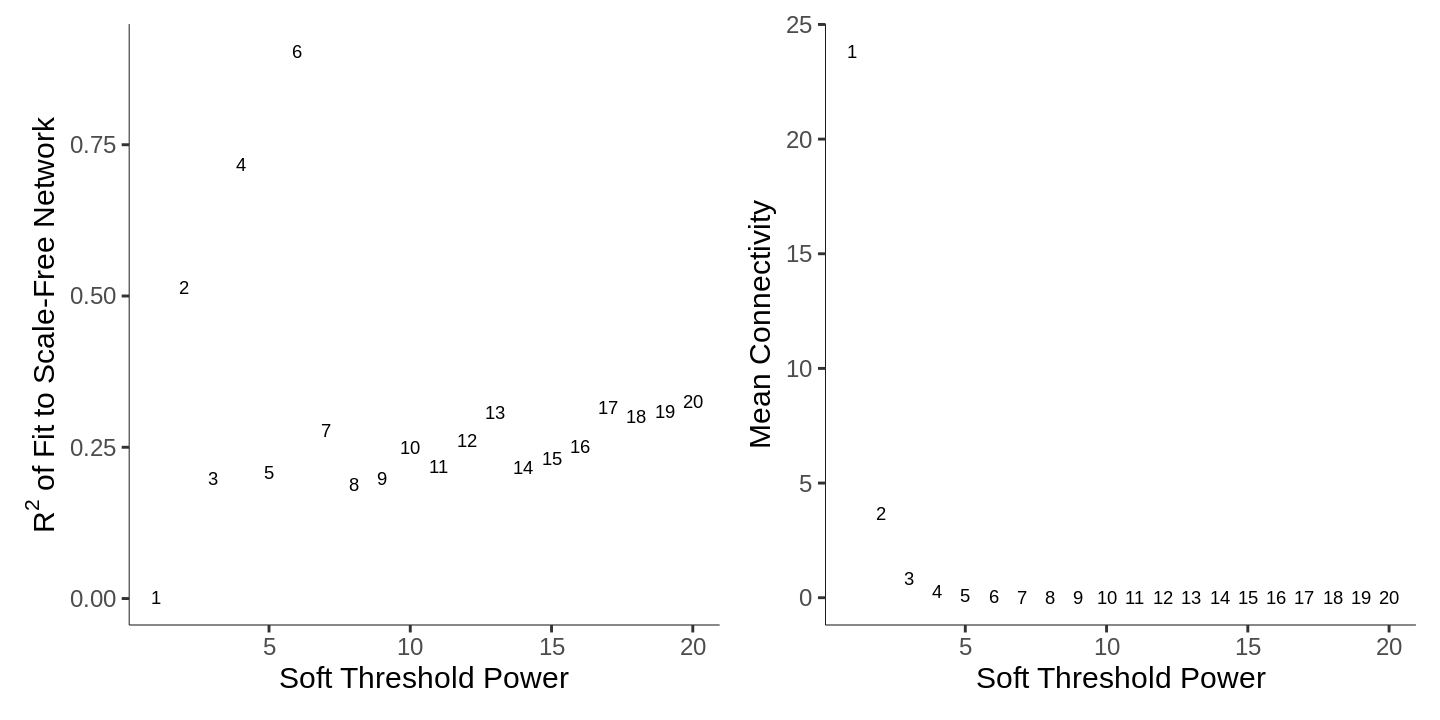

In [7]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [8]:
print(soft.threshold)

[1] 6


## Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=6$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [9]:
adjacency.matrix = adjacency(protein.exp, type="unsigned", corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="none"), power=soft.threshold)

TOM.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/protein_expression/", recursive=TRUE)
saveRDS(TOM.matrix, file="~/gains_team282/nikhil/expression/protein_expression/TOM.matrix.RDS")

TOM.dist = 1 - TOM.matrix

..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/protein_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/protein_expression' already exists”


## Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

In [10]:
dendrogram = hclust(as.dist(TOM.dist), method="average")

svg(filename="04_Expression/results/protein_expression_dendrogram.svg", width=8, height=5)
plot(dendrogram, labels=FALSE, main="Protein Expression TOM Dendrogram")
dev.off()

dynamic.mods = cutreeDynamic(
  dendro=dendrogram, distM=TOM.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.dist)

png 
  2

 ..cutHeight not given, setting it to 1  ===>  99% of the (truncated) height range in dendro.
 ..done.


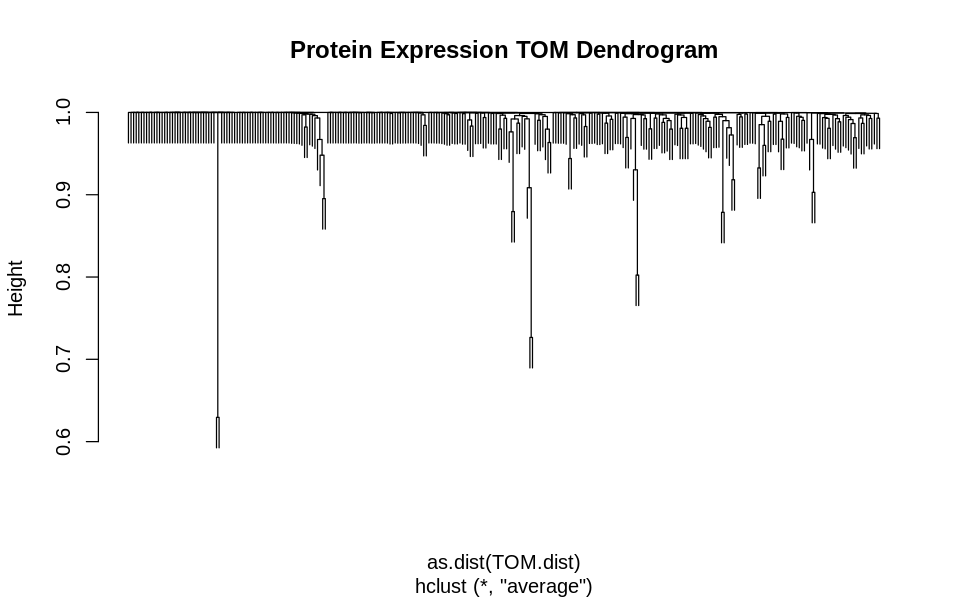

In [11]:
options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="Protein Expression TOM Dendrogram")

## Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [12]:
connectivity <- intramodularConnectivity(TOM.matrix, colors=dynamic.mods)
rownames(connectivity) <- colnames(protein.exp)

## Co-Expression Module Size Distribution

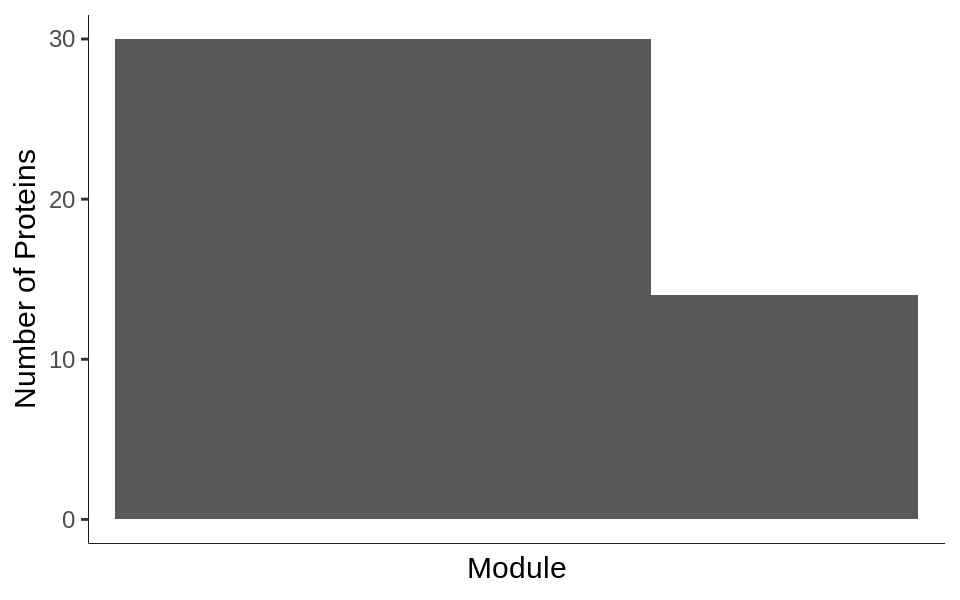

In [13]:
plot.data <- as.data.frame(table(dynamic.mods)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Proteins") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/protein_coexpression_module_sizes.svg", width=8, height=5)

## Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigenproteins, the variance explained by each eigenprotein, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigenprotein of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigenprotein tells us how well the eigenprotein captures the overall variation found within the module expression data.

In [14]:
### Module Assignment

protein.list <- colnames(protein.exp)

mod.assignment <- dynamic.mods
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Protein=protein.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Protein)

write.csv(modules, "~/gains_team282/nikhil/expression/protein_expression/modules.csv", row.names=F)

### Eigenproteins

eigengenes.result <- moduleEigengenes(protein.exp[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(protein.exp)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/protein_expression/eigenproteins.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/protein_expression/variance.explained.csv", row.names=F)

### Connectivity

connectivity <- connectivity[modules$Protein,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/protein_expression/connectivity.csv")